### Hilbert Space

In [1]:
from qutip import *
import numpy as np
import scipy.optimize as sciop
import matplotlib.pyplot as plt
import cython
import skopt

# define idealised basis
basis_labels = {
    'cav_bin': 0,
    'spont_bin': 1,
    'g':2,
    'u':3,
    'x':4
}
N=len(basis_labels)

g_ket = basis(N, basis_labels['g'])
u_ket = basis(N, basis_labels['u'])
x_ket = basis(N, basis_labels['x'])

# define basic operators
gx_swap = basis(N, basis_labels['g']) * basis(N, basis_labels['x']).dag()
ux_swap = basis(N, basis_labels['u']) * basis(N, basis_labels['x']).dag()

g_id = fock_dm(N, basis_labels['g'])
u_id = fock_dm(N, basis_labels['u'])
x_id = fock_dm(N, basis_labels['x'])
cav_id = fock_dm(N, basis_labels['cav_bin'])
spont_id = fock_dm(N, basis_labels['spont_bin'])

cav_decay = basis(N, basis_labels['cav_bin']) * basis(N, basis_labels['g']).dag()
spont_decay = basis(N, basis_labels['spont_bin']) * basis(N, basis_labels['x']).dag()

## Parameters

In [2]:
delta_stirap = 1
delta_C = delta_stirap
delta_L = delta_stirap

gamma = 1
kappa = gamma*1

coops = [2,5,10,20,50,100,125,150,200]


RUNTIME = 1/gamma
STEPS_PER_SEC = 1000
NUM_STEPS = round(STEPS_PER_SEC*RUNTIME + 1)
if type(RUNTIME) == float:
    if RUNTIME < 1:
        lin_factor = 1/RUNTIME
        RUNTIME = lin_factor*RUNTIME
    else:
        lin_factor = 10
        RUNTIME = np.ceil(RUNTIME*10)
t = np.linspace(0, int(RUNTIME), NUM_STEPS)
t /= lin_factor

print(t)
# define pulse shape
wSTIRAP = np.pi/RUNTIME
H_args = {
    'wSTIRAP': wSTIRAP
}
flat_pulse = '1'
sin_pulse = 'np.sin(wSTIRAP*t)**2'

c_ops = [np.sqrt(gamma)*spont_decay, np.sqrt(kappa)*cav_decay]

[0.    0.001 0.002 ... 0.998 0.999 1.   ]


### Efficiency Functions

In [3]:
def find_efficiency(omega, delta, cooperativity, psi0=u_ket, pulse_shape=sin_pulse):

    g0 = (kappa*gamma*cooperativity)**0.5

    theta = np.arctan(omega/2*g0)

    H0 = delta*g_id + delta*u_id - g0*(gx_swap + gx_swap.dag())
    H1 = -omega/2*(ux_swap + ux_swap.dag())
    H=[H0, [H1, pulse_shape]]

    result = mesolve(H, psi0, t, c_ops, [], args=H_args)

    photon_emission_prob = expect(cav_id, result.states[-1])
    spont_decay_prob = expect(spont_id, result.states[-1])
    print(f'norm: {photon_emission_prob + spont_decay_prob}')

    return photon_emission_prob/(photon_emission_prob + spont_decay_prob)


In [4]:
def optimise_peak_rabi(cooperativity, omega_guess, delta_guess):

    def find_neg_efficiency(omega_delta, psi0=u_ket, pulse_shape=sin_pulse):

        omg = omega_delta[0]
        delta = omega_delta[1]

        g0 = (kappa*gamma*cooperativity)**0.5

        H0 = delta*g_id + delta*u_id - g0*(gx_swap + gx_swap.dag())
        H1 = -omg/2*(ux_swap + ux_swap.dag())
        H=[H0, [H1, pulse_shape]]

        result = mesolve(H, psi0, t, c_ops, [], args=H_args)

        photon_emission_prob = expect(cav_id, result.states[-1])
        spont_decay_prob = expect(spont_id, result.states[-1])

        return -photon_emission_prob/(photon_emission_prob + spont_decay_prob)

    
    return skopt.gp_minimize(find_neg_efficiency, [[omega_guess/5, 5*omega_guess], [0, 50]],x0=[omega_guess, delta_guess], n_calls=50)

In [5]:
v = optimise_peak_rabi(30, 230, 30)

In [6]:
print(v.x)
print(v.fun)

[227.8588091817, 0]
-0.7931394922441839


In [8]:
omgs = np.linspace(180, 250, 10)
effs = [find_efficiency(omg, 0, 0) for omg in omgs]

norm: 0.2569240930683608
norm: 0.2543610867450412
norm: 0.25150757462319623
norm: 0.24869697115579922
norm: 0.24622523635413254
norm: 0.24433828486542786


Exception: Could not convert string to importable function, tmpfile:cqobjevo_compiled_coeff_1072005236262.pyx

NameError: name 'omgs' is not defined

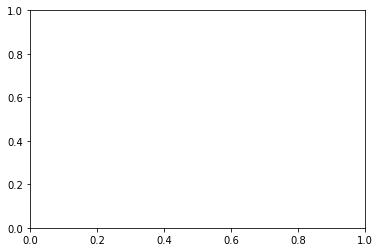

In [ ]:
fig, axes = plt.subplots(1,1)
axes.plot(omgs, effs)
axes.set_xlabel('$\Omega_P$')
axes.set_ylabel('Efficiency')

In [9]:
omgs = np.linspace(1500,2500, 10)
effs = [find_efficiency(omg, 30, 30) for omg in omgs]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\Users\reube\AppData\Local\Programs\Python\Python39\lib\site-packages\pyximport\pyxbuild.py", line 102, in pyx_to_dll
    dist.run_commands()
  File "c:\Users\reube\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\dist.py", line 969, in run_commands
    self.run_command(cmd)
  File "c:\Users\reube\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\dist.py", line 1208, in run_command
    super().run_command(command)
  File "c:\Users\reube\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\dist.py", line 988, in run_command
    cmd_obj.run()
  File "c:\Users\reube\AppData\Local\Programs\Python\Python39\lib\site-packages\Cython\Distutils\old_build_ext.py", line 186, in run
    _build_ext.build_ext.run(self)
  File "c:\Users\reube\AppData\Local\Programs\Python\Python39\lib\site-packages\setuptools\_distutils\command\build_ext.py", line 346, in run
    self.build_extension

TypeError: object of type 'NoneType' has no len()

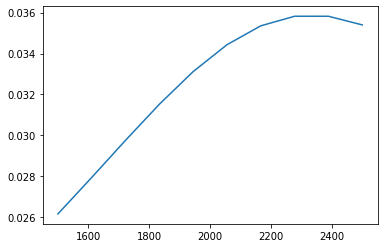

In [ ]:
fig, axes = plt.subplots(1,1)
axes.plot(omgs, effs)

In [16]:
print(find_efficiency(2340, 0, 20))

norm: 0.39257428251930493
0.37279627297886586
